In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
import pyiast as iast

In [38]:
import numpy as np

In [40]:
gases = ["N2", "CH4"]

In [41]:
df_dict = {"N2" : pd.read_csv("N2_HKUST-1.csv", comment='#'), "CH4" : pd.read_csv("CH4_HKUST-1.csv", comment='#')}

In [42]:
df_dict["N2"]["p(bar)"] = df_dict["N2"]["p(MPa)"] * 10

In [43]:
"""
unit conversion
cm3/g --> mmol/g

* L/1000cm3 * mol/22.4L * 1000mmol/mol
"""

'\nunit conversion\ncm3/g --> mmol/g\n\n* L/1000cm3 * mol/22.4L * 1000mmol/mol\n'

In [44]:
df_dict["CH4"]["N(mmol/g)"] = df_dict["CH4"]["cm3/g"] / 22.4

In [45]:
isotherm_dict = {}
for gas in gases:
    isotherm_dict[gas] = iast.ModelIsotherm(df_dict[gas], loading_key="N(mmol/g)", pressure_key="p(bar)", model="Langmuir")

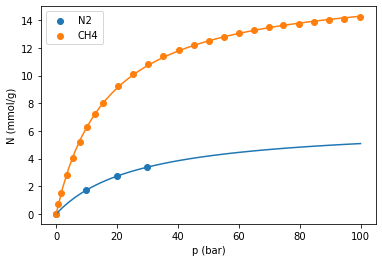

In [51]:
plt.figure()

p_range = np.linspace(0, 100)

for gas in gases:
    plt.scatter(df_dict[gas]["p(bar)"], df_dict[gas]["N(mmol/g)"], marker='o', label=gas)
    plt.plot(p_range, isotherm_dict[gas].loading(p_range))
    
#plt.xlim(0, 2)
plt.xlabel("p (bar)")
plt.ylabel("N (mmol/g)")
plt.legend()

In [78]:
total_p = 1.0 # bar
mol_fxns = np.array([0.04, 0.96])

q = iast.iast(total_p * mol_fxns, [isotherm_dict[gas] for gas in gases])

In [79]:
x_ch4 = np.linspace(0, 1)
m_ads = np.zeros(len(x_ch4))
mol_wts = {"N2" : 28., "CH4" : 16.}

In [80]:
for i in range(len(x_ch4)):
    if x_ch4[i] == 0:
        m_ads[i] = isotherm_dict["N2"].loading(total_p) * mol_wts["N2"] / 1000
        continue
    if x_ch4[i] == 1:
        m_ads[i] = isotherm_dict["CH4"].loading(total_p) * mol_wts["CH4"] / 1000
        continue
        
    mol_fxns = np.array([1 - x_ch4[i], x_ch4[i]])
    q = iast.iast(total_p * mol_fxns, [isotherm_dict[gas] for gas in gases])
    # q: mmol/g mof
    # mol_wts: g gas/mol 
    # m_ads: g gas/g mof
    m_ads[i] = np.sum([q[j] * mol_wts[gases[j]] for j in range(len(gases))]) / 1000

Text(0.5, 1.0, 'Calibration Curve')

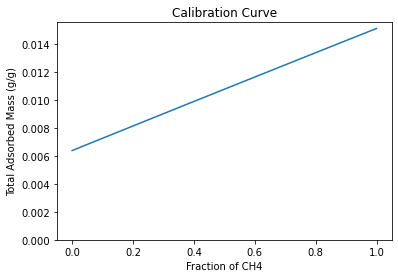

In [81]:
plt.figure()
plt.plot(x_ch4, m_ads)
plt.ylim(ymin=0)
plt.xlabel("Fraction of CH4")
plt.ylabel("Total Adsorbed Mass (g/g)")
plt.title("Calibration Curve")